# INFO 2950 Project Phase IV

By Michael Wang, John Lo, Patricio Fraga-Errecart, and Colin Hoffer 

---
## Introduction

We began this project by first thinking about what sorts of factors can effect housing prices within the United States. After some deliberation, we decided to narrow our focus to housing prices within various cities, and chose potential factors based on what we each thought might affect housing prices. We came up with two distinct research questions:

- What factors (including education, taxes, weather, etc.) have the highest correlation with typical housing prices in cities in the USA?
- Can such factors be used to accurately predict housing prices within the USA?


After performing our analyses, we did not find particularly high r^2 values for any of our suggested factors, although some of the factors landed within the .4 to .6 range, which demonstrate some correlation. We suspected this was due to the high variability of housing prices within various cities, as well as the variation of housing prices from city to city. We also have no reference point for a "significant" correlation for real estate data. These values could potentially be significant for the data that we chose to analyze.

Overall, the best predictors for housing prices seem to be percentage of educated population, income, and climate.

---
## Data Description



### Data Overview

Because our Data Collection and Cleaning was quite extensive, we placed it in a separate Jupyter file.

In our final dataset (msazhvi), the rows represent 52 Metropolitan Statistical Areas (MSAs) throughout different geographical regions of the US. The columns are different attributes of each MSA, including typical home value (2018 ZHVI), average percent of highest education attained, average income, average property taxes, average rent as a percent of income, average high temperature of the year, average low temperature of the year, average mean temperature of the year, and various forms of crime per 100k individuals.

The home value data in the 2018 ZHVI is sourced from Zillow and their public data. Zillow has their proprietary home value estimates called 'Zestimates' sourced from a variety of metrics. These metrics come from third party sources, some which are not disclosed due to zestimates being Zillow's special metric. However, other sources are known, such as data.gov, Google Places, and Multiple Listing Service (MLS) data. MLS data is used by real estate brokers to make transactions more efficient, therefore, this data provides Zillow with pricing info. Zillow receives MLS data directly in a data feed when brokers opt into have their listing syndicated by Zillow. Because of their sources and direct connections to real-time transactions, Zillow is able to get provide accurate aggregated estimates for MSAs and their housing prices. 

Much of the other data comes directly from the census, including average percent of highest education attained, average income, average property taxes, average rent as a percent. Specifically, this data comes from the American Community Survey Data from the census, which is collected every year rather than every 10 years to provide 5-year estimates regarding community metrics. This data is sent out to select members of communities on a rotating basis to guage a sample size to help estimate the metrics. 

The crime data comes from the FBI and is sorted by all MSAs throughout the country. The data is posted every year, however not every MSA is available each year. The data provides metrics on violent crimes and thievery. Because the FBI is federal, they do not collect the data themselves. Law enforcement agencies around the country provide the data to the FBI yearly, at which point they compile and publish the Uniform Crime Report. 

The temperature data comes from NOAA and was taken only from the major city in each MSA. This is because the data is not published by MSA but still provides the most accurate estimate since the city is typically located in the geographical center of the MSA. NOAA collects their real-time data from satelites, bouys, weather stations, scientists, and local stations. An interactive map of the US allows the user to click on a geographical region and then a city within. Data from each city had to be collected individually and compiled into a csv by hand, as there was no way to download all available data. 

This dataset was created in order to more effectively compare various factors and their effects on typical home values within cities. We decided to focus on an entire year (2018), so we had to consolidate the ZHVI data, which was calculated monthly. We also focused on Metropolitan Statistical Areas surrounding cities, so we also consolidated the Census data by performing weighted averages of the county variables. A more detailed look at this process is above.

All the data we collected was free and we required no funding. There are links in the Data Collection section to the specific sources where we gathered our data from. 

We chose factors somewhat arbitrarily; we chose them based on what we suspected would have an effect on typical house price.


In [14]:
import pandas as pd
msazhvi=pd.read_csv("finaldataset.csv")
msazhvi.head()

,Unnamed: 0,RegionName,2018 ZHVI,Mean Percent HS/Equivalent Educated,Mean Percent Bachelor's Degree Holding,Mean Percent Postgraduate Educated,Mean Income,Mean Property Tax,Mean Rent as a Percentage of Income,Mean High Temp,Mean Low Temp,Mean Annual Temp,Violent Crime per 100k,Robbery per 100k,Property Crime per 100k,Burglary per 100k
0,1,"New York, NY",470289.833333,0.194727,0.181194,0.123487,97918.579350,4080.629834,16.965818,97.0,5.0,53.4,332.9,107.5,1335.6,152.6
1,2,"Los Angeles-Long Beach-Anaheim, CA",658484.166667,0.163148,0.166903,0.083846,91473.680944,2495.099228,19.548604,101.0,38.0,66.0,494.8,162.7,2246.9,390.5
2,3,"Chicago, IL",236369.000000,0.196159,0.170818,0.105563,84038.028714,3621.713256,11.552303,95.0,-7.0,50.5,443.0,166.8,2081.6,330.7
3,4,"Dallas-Fort Worth, TX",240213.666667,0.178769,0.159131,0.083052,83355.597543,2734.003335,13.185533,106.0,18.0,68.0,351.0,103.6,2232.7,360.9
4,6,"Houston, TX",207693.416667,0.182125,0.140816,0.077357,75547.037009,2507.561749,12.354341,103.0,26.0,70.3,593.1,176.7,2604.7,443.5


---
## Preregistration Statement

We promised to perform the following analyses:
- Multivariable linear regression predicting housing prices based on all factors to test correlation between these factors and the housing price.
- Permutation tests on the strongest correlated variables to see if the relationships are generalizable

---
## Data Analysis

---
### Education, Income, Property Tax, Rent Data Analysis

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import poisson, ttest_ind

For our education analysis, we wanted to perform analysis using education as a single factor, since we believed it was more relevant to talk about people who obtained at least a high school diploma as opposed to specifically people whose highest attainment was a high school diploma, or a bachelor's degree, or a postgraduate degree.

In [16]:

##giving different weights to each level of education so we create an education score later 
msazhvi['Education Score'] = msazhvi['Mean Percent HS/Equivalent Educated'] + 1.8*msazhvi["Mean Percent Bachelor's Degree Holding"] + 2.3*msazhvi['Mean Percent Postgraduate Educated']


In [17]:
model = LinearRegression()
##model.fit(msazhvi[['Mean Percent HS/Equivalent Educated',"Mean Percent Bachelor's Degree Holding",'Mean Percent Postgraduate Educated','Mean Income', 'Mean Property Tax', 'Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])
model.fit(msazhvi[['Education Score', 'Mean Income', 'Mean Property Tax', 'Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])

LinearRegression()

In [18]:
print('Education Score Slope: ' + str(model.coef_[0]))
print('Income Slope: ' + str(model.coef_[1]))
print('Property Tax Slope: ' + str(model.coef_[2]))
print('RPI Slope: ' + str(model.coef_[3]))

Education Score Slope: 288401.09748791787
Income Slope: 5.367968171754194
Property Tax Slope: -22.586712464529683
RPI Slope: 23453.983237070337


In [19]:
msazhvi['Predictions'] = model.predict(msazhvi[['Education Score', 'Mean Income', 'Mean Property Tax', 'Mean Rent as a Percentage of Income']])
msazhvi['Difference'] = msazhvi['2018 ZHVI'] - msazhvi['Predictions']

In [20]:
print('R-Squared: ' + str(model.score(msazhvi[['Education Score', 'Mean Income', 'Mean Property Tax', 'Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])))

R-Squared: 0.6405299730326726


R-Squared: 0.26533077563629326


Text(0, 0.5, '2018 ZHVI')

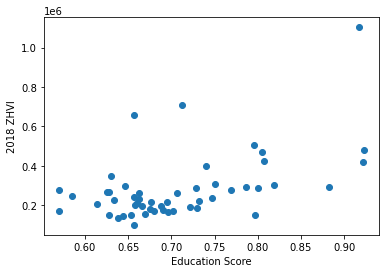

In [21]:
edModel = LinearRegression()
edModel.fit(msazhvi[['Education Score']], msazhvi['2018 ZHVI'])
print('R-Squared: ' + str(edModel.score(msazhvi[['Education Score']], msazhvi['2018 ZHVI'])))
plt.scatter(msazhvi['Education Score'], msazhvi['2018 ZHVI'])
plt.xlabel('Education Score')
plt.ylabel('2018 ZHVI')

R-Squared: 0.5614094889931451


Text(0, 0.5, '2018 ZHVI')

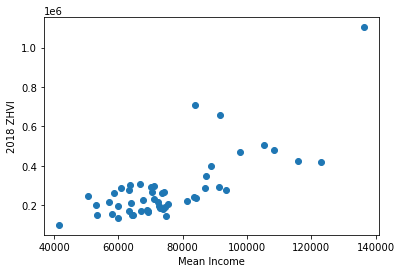

In [22]:
incModel = LinearRegression()
incModel.fit(msazhvi[['Mean Income']], msazhvi['2018 ZHVI'])
print('R-Squared: ' + str(incModel.score(msazhvi[['Mean Income']], msazhvi['2018 ZHVI'])))
plt.scatter(msazhvi['Mean Income'], msazhvi['2018 ZHVI'])
plt.xlabel('Mean Income')
plt.ylabel('2018 ZHVI')

R-Squared: 0.2745815159496049


Text(0, 0.5, '2018 ZHVI')

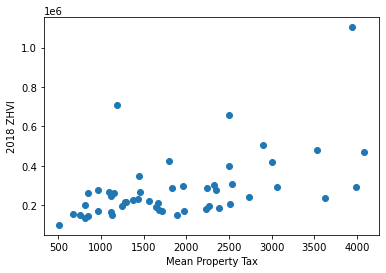

In [23]:
taxModel = LinearRegression()
taxModel.fit(msazhvi[['Mean Property Tax']], msazhvi['2018 ZHVI'])
print('R-Squared: ' + str(taxModel.score(msazhvi[['Mean Property Tax']], msazhvi['2018 ZHVI'])))
plt.scatter(msazhvi['Mean Property Tax'], msazhvi['2018 ZHVI'])
plt.xlabel('Mean Property Tax')
plt.ylabel('2018 ZHVI')

R-Squared: 0.33771713594370345


Text(0, 0.5, '2018 ZHVI')

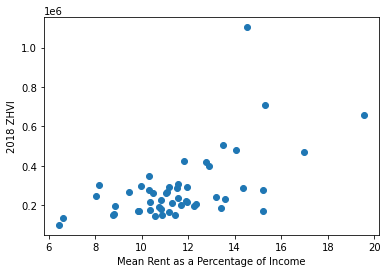

In [24]:
rentModel = LinearRegression()
rentModel.fit(msazhvi[['Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])
print('R-Squared: ' + str(rentModel.score(msazhvi[['Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])))
plt.scatter(msazhvi['Mean Rent as a Percentage of Income'], msazhvi['2018 ZHVI'])
plt.xlabel('Mean Rent as a Percentage of Income')
plt.ylabel('2018 ZHVI')

In [25]:
##%matplotlib notebook
##from mpl_toolkits.mplot3d import Axes3D

##twoDModel = LinearRegression()
##twoDModel.fit(msazhvi[['Mean Income', 'Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])

##inc_pred = np.linspace(40000, 140000, 200)
##RPI_pred = np.linspace(6, 20, 200)

##x, y = np.meshgrid(inc_pred, RPI_pred)

##samples = pd.DataFrame({'Income':inc_pred, 'RPI':RPI_pred})

#samples = pd.DataFrame({'Income':x, 'RPI':y})

##pred = twoDModel.predict(samples)

##fig = plt.figure()
##ax = fig.add_subplot(111, projection='3d')

##ax.scatter(msazhvi['Mean Income'], msazhvi['Mean Rent as a Percentage of Income'], msazhvi['2018 ZHVI'], c='r')
##ax.plot(inc_pred, RPI_pred, pred, c='blue')
##ax.legend
##ax.set_xlabel('Mean Income')
##ax.set_ylabel('Mean Rent as a Percentage of Income')
##ax.set_zlabel('2018 ZHVI')

##plt.show()

In [26]:
##msazhvi

### Crime Data Analysis

In [27]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

In [28]:
crimemodel = LinearRegression()
crimemodel.fit(msazhvi[["Violent Crime per 100k", "Robbery per 100k", "Property Crime per 100k", "Burglary per 100k"]], msazhvi["2018 ZHVI"])

LinearRegression()

In [29]:
print('Violent Crime Slope: ' + str(crimemodel.coef_[0]))
print('Robbery Slope: ' + str(crimemodel.coef_[1]))
print('Property Crime Slope: ' + str(crimemodel.coef_[2]))
print('Burglary Slope: ' + str(crimemodel.coef_[3]))

Violent Crime Slope: -645.3454380240722
Robbery Slope: 2090.187196829615
Property Crime Slope: 102.94551985578293
Burglary Slope: -380.8115071429349


In [30]:
msazhvi["Crime Predictions"] = crimemodel.predict(msazhvi[["Violent Crime per 100k", "Robbery per 100k", "Property Crime per 100k", "Burglary per 100k"]])
msazhvi['Crime Difference'] = msazhvi['2018 ZHVI'] - msazhvi['Crime Predictions']

In [31]:
print("Crime R-squared: " + str(crimemodel.score(msazhvi[["Violent Crime per 100k", "Robbery per 100k", "Property Crime per 100k", "Burglary per 100k"]], msazhvi["2018 ZHVI"])))

Crime R-squared: 0.37076023238578015


In [32]:
vioModel = LinearRegression()
vioModel.fit(msazhvi[["Violent Crime per 100k"]], msazhvi['2018 ZHVI'])
print('Violent Crime R-Squared: ' + str(vioModel.score(msazhvi[['Violent Crime per 100k']], msazhvi['2018 ZHVI'])))

Violent Crime R-Squared: 0.03071125366546168


In [33]:
robModel = LinearRegression()
robModel.fit(msazhvi[["Robbery per 100k"]], msazhvi['2018 ZHVI'])
print('Robbery R-Squared: ' + str(robModel.score(msazhvi[['Robbery per 100k']], msazhvi['2018 ZHVI'])))

Robbery R-Squared: 0.031028909026894036


In [34]:
propModel = LinearRegression()
propModel.fit(msazhvi[["Property Crime per 100k"]], msazhvi['2018 ZHVI'])
print('Property Crime R-Squared: ' + str(propModel.score(msazhvi[['Property Crime per 100k']], msazhvi['2018 ZHVI'])))

Property Crime R-Squared: 1.1151738287251689e-05


In [35]:
burgModel = LinearRegression()
burgModel.fit(msazhvi[["Burglary per 100k"]], msazhvi['2018 ZHVI'])
print('Burglary R-Squared: ' + str(burgModel.score(msazhvi[['Burglary per 100k']], msazhvi['2018 ZHVI'])))

Burglary R-Squared: 0.030495704317751393


In [36]:
##propCrimeArray = msazhvi["Property Crime per 100k"].to_numpy().astype(int)
##zhviArray = msazhvi['2018 ZHVI'].to_numpy().astype(int)

### Climate Data Analysis

In [37]:
tempmodel = LinearRegression()
tempmodel.fit(msazhvi[["Mean High Temp", "Mean Low Temp", "Mean Annual Temp"]], msazhvi["2018 ZHVI"])

LinearRegression()

In [38]:
print('Mean High Temp Slope: ' + str(tempmodel.coef_[0]))
print('Mean Low Temp Slope: ' + str(tempmodel.coef_[1]))
print('Mean Annual Temp: ' + str(tempmodel.coef_[2]))

Mean High Temp Slope: 3138.8835579338484
Mean Low Temp Slope: 15841.746921314796
Mean Annual Temp: -25881.458609540554


In [39]:
##msazhvi["Climate Predictions"] = tempmodel.predict(msazhvi[["Mean High Temp", "Mean Low Temp", "Mean Annual Temp"]])

In [40]:
print("Climate R-squared: " + str(tempmodel.score(msazhvi[["Mean High Temp", "Mean Low Temp", "Mean Annual Temp"]], msazhvi["2018 ZHVI"])))

Climate R-squared: 0.5881900961047768


Mean High Temp R-Squared: 0.027844518248844263


Text(0, 0.5, '2018 ZHVI')

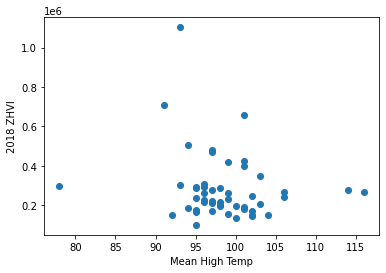

In [41]:
highModel = LinearRegression()
highModel.fit(msazhvi[["Mean High Temp"]], msazhvi['2018 ZHVI'])
print('Mean High Temp R-Squared: ' + str(highModel.score(msazhvi[['Mean High Temp']], msazhvi['2018 ZHVI'])))
plt.scatter(msazhvi['Mean High Temp'], msazhvi['2018 ZHVI'])
plt.xlabel('Mean High Temp')
plt.ylabel('2018 ZHVI')

Mean Low Temp R-Squared: 0.18753060643542352


Text(0, 0.5, '2018 ZHVI')

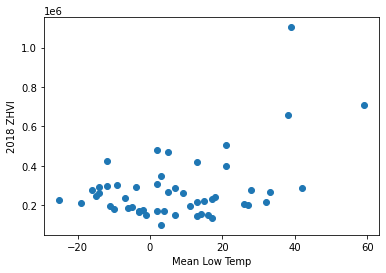

In [42]:
lowModel = LinearRegression()
lowModel.fit(msazhvi[["Mean Low Temp"]], msazhvi['2018 ZHVI'])
print('Mean Low Temp R-Squared: ' + str(lowModel.score(msazhvi[['Mean Low Temp']], msazhvi['2018 ZHVI'])))
plt.scatter(msazhvi['Mean Low Temp'], msazhvi['2018 ZHVI'])
plt.xlabel('Mean Low Temp')
plt.ylabel('2018 ZHVI')

Mean Annual Temp R-Squared: 0.005597336113390083


Text(0, 0.5, '2018 ZHVI')

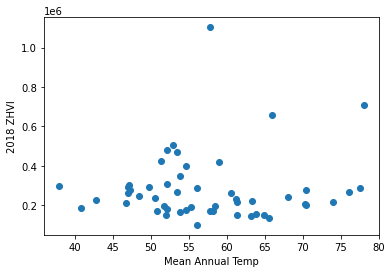

In [43]:
annualModel = LinearRegression()
annualModel.fit(msazhvi[["Mean Annual Temp"]], msazhvi['2018 ZHVI'])
print('Mean Annual Temp R-Squared: ' + str(annualModel.score(msazhvi[['Mean Annual Temp']], msazhvi['2018 ZHVI'])))
plt.scatter(msazhvi['Mean Annual Temp'], msazhvi['2018 ZHVI'])
plt.xlabel('Mean Annual Temp')
plt.ylabel('2018 ZHVI')

Temperature Range" R-Squared: 0.24775420146027816


Text(0, 0.5, '2018 ZHVI')

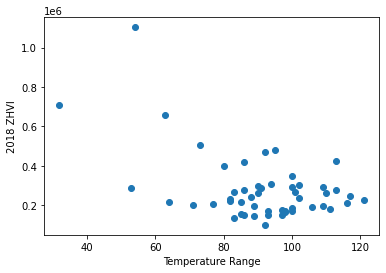

In [44]:
msazhvi["Temperature Range"] = msazhvi['Mean High Temp'] - msazhvi['Mean Low Temp']
rangeModel = LinearRegression()
rangeModel.fit(msazhvi[["Temperature Range"]], msazhvi['2018 ZHVI'])
print('Temperature Range" R-Squared: ' + str(rangeModel.score(msazhvi[['Temperature Range']], msazhvi['2018 ZHVI'])))
plt.scatter(msazhvi['Temperature Range'], msazhvi['2018 ZHVI'])
plt.xlabel('Temperature Range')
plt.ylabel('2018 ZHVI')

---
## Evaluation of Significance

# F Test
H0: B_high = B_low = B_annual = 0

HA: B_j != 0 for at least 1 value of j


F = MSM/MSE = (SSR/DFM) / (SSE/DFE) = (Σ(yi^ - y)^2 / (p - 1)) / (Σ(yi - yi^)^2 / (n - p))

n = 49 (data points)

p = 4 (parameters)

In [45]:
msazhvi["Climate Predictions"] = tempmodel.predict(msazhvi[["Mean High Temp", "Mean Low Temp", "Mean Annual Temp"]])
y_mean = msazhvi["Climate Predictions"].mean()
y_predictions = msazhvi["Climate Predictions"].tolist()
actual_y = msazhvi["2018 ZHVI"].tolist()
ssr = 0
sse = 0
for i in range(len(y_predictions) - 1):
    ssr += (y_predictions[i] - y_mean) ** 2
    sse += (actual_y[i] - y_predictions[i]) ** 2
f = (ssr/3) / (sse/45)
print("F-Value: " + str(f))

F-Value: 21.385023087902074


With an F-value of 21.8545, we have sufficient evidence to reject the null hypothesis at a = 0.05. Thus, we can conclude that at least one of the independent variables that make up the Climate metric in in the model is statistically significant. As such, we can conclude that there is a real, tangible relationship between how much properties are worth in a metropolitan area and the local weather patterns, which generally increases as the weather gets warmer.


---
## Interpretations


### Education and Economic Factors

#### Multivariate Linear Regression
The MLR slopes from above can be interpreted as follows:
- Every time the average percentage of the population that is at least high school educated goes up by 1 percentage point, the typical house price for that city goes up by around 3000 dollars.
- Every time the mean income for a city goes up by 1 dollar, the typical house price increases by 5 dollars. 
- Every time the average property tax for a city increases by a dollar, the typical house price decreases by 26 dollars.
- Finally, every time the average percent of income spent on rent increases by 1 percentage point, the typical house price for that city goes up by 227 dollars.

The r^2 value from the MLR is .65, which may not seem particularly high, but it implies that there is at least some number of housing prices that can be predicted with these factors.

Overall, there seems to be a relatively large positive correlation between the amount of high-school educated individuals in a city and the typical house price. However, this does not necessarily point to a causative relationship. While a better education may lead to a higher income, there is also a chance that wealthier individuals (who can afford more expensive homes), are more likely to pursue or have their children pursue a better education.

The positive correlation between income and housing price, albeit small, can be explained by the idea that individuals with higher paying jobs have more disposable income. In response, housing prices could potentially increase to "keep up" with higher incomes.

We are unsure as to why there is a negative relationship between property taxes and housing prices when performing MLR.

The positive correlation between percent of income spent on rent and housing price seems relatively self-evident. The more expensive it is to rent a house, the more expensive it should be to own a house. This does not necessarily imply causation.

#### Univariate Linear Regressions

For the education linear regression, there seems to be a slightly positive slope with a r^2 value of .27. This doesn't seem extremely statistically significant. It seems that education has a higher correlation with housing prices when taking other factors into account.

For the mean income linear regression, there seems to be a slightly positive slope with a r^2 value of .57. This is somewhat higher than the other linear regressions, which seems to imply that some housing prices can be predicted utilizing mean income.

For the linear regressions of property tax and percentage of income spent on rent, there are slightly positive slopes and low r^2 values. They don't seem statistically significant.

### Crime Data

Both the Multivariate and Univariate Linear Regessions had relatively low r^2 values, so crime doesn't seem to be an effective predictor of housing prices.

### Climate Data

#### Multivariate Linear Regression
The MLR slopes can be interpreted as follows:
- Every time the average high temperature increases by 1 degree Fahrenheit, the housing price increases by around 3000 dollars.
- Every time the average low temperature increases by 1 degree Fahrenheit, the housing price increases by around 16000 dollars.
- Every time the average annual temperature increases by 1 degree Fahrenheit, the housing price decreases by around 26000 dollars.

The r^2 value from the MLR is .59, which may not seem particularly high, but it implies that there is at least some number of housing prices that can be predicted by temperature. 

It seems that the average overall temperature has the largest slope with housing prices. If housing prices are used to determine desirability of living within a location, perhaps higher overall temperatures are less desirable, and lead to a lower price. In addition, average low temperatures also have a relatively high slope. Perhaps people care more about how cold a location has the potential to be rather than how hot a location can be. This would mean that locations with milder weather are more desirable.

The univariate linear regressions did not have particularly high r^2 values, so they don't seem to be statistically significant. However, when calculating average temperature range by subtracting the mean high and mean low temperatures, there is a negative relationship with housing prices and a low r^2 value. This could potentially indicate that less variable weather is more desirable, which leads to higher house prices.

## Conclusion

The strongest predictors for housing prices seem to be percentage of educated population, income, and climate.

---
## Limitations

Much of our data is quite interrelated (Education, Income, Taxes, etc.), so the correlations that we discover are not necessarily causative relationships. It is also difficult to interpret the Multivariate Linear Regressions with this fact in mind.

There could also be limitations in the data that we have collected. Our Education and Economic data is calculated for each MSA by finding the weighted means of the individual counties that make up each MSA. There could be outliers that skew these values.

We are also limited in that we somewhat arbitrarily chose factors that we thought could affect housing prices without any prior knowledge or expertise in how real estate prices can vary or change.


---
## Source Code

[Repository](https://github.com/Wichaelian/INFO2950)

---
## Questions for Reviewers

- Our data overview section shares a lot of information with our data collection and cleaning section. Should we move all the information to just one section?

- When we put all of our data into the dataset, we did not take into account the difference in units between different factors. For example, some factors are percentages (rent as a percentage of income, education), while others are dollar values. We are unsure if this disparity would have an effect on our multivariate linear regressions. Should we make it so all of the factors have similar units? I.E. multiply the percentages by 100, or find the crime rate percentage instead of over 100k?

- We are having trouble performing a permutation test on a multivariate linear regression. Is it possible to do? Should we even try? 

- Should we perform other tests like a train/test split or a bootstrap test?

- We divided our multivariate linear regressions between education and economic data, climate data, and crime data. Would it be worthwhile to perform a MLR on all of the factors to predict median housing price, even though the r^2 value always increases when more factors are introduced?